In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

##LOAD LLAVA 13B

In [ ]:
#@title load function
%%capture

%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA

!pip install -q transformers==4.36.2
!pip install -q gradio .

from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

import requests
from PIL import Image
from io import BytesIO
from transformers import TextStreamer

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

%cd ..

In [ ]:
#@title LLAVA caption image function
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria

def caption_image(image_input, prompt):
    if isinstance(image_input, np.ndarray):
        # Convert numpy array to PIL Image
        image_input = image_input[:, :, ::-1]
        image = Image.fromarray(image_input).convert('RGB')
    elif isinstance(image_input, str):
        if image_input.startswith('http') or image_input.startswith('https'):
            response = requests.get(image_input)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_input).convert('RGB')
    else:
        raise ValueError("image_input must be a numpy array or a string.")

    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=50, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return output

## Captions Frames dal Video

In [ ]:
#@title get_frames function
import cv2
from IPython.display import Image as ImageIPython, display

import warnings
warnings.filterwarnings('ignore')

def get_frames(path, labels, add_width, add_height):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, labels.iloc[0]['framenum'])  # Set the starting frame
    progress_bar = tqdm(total=len(labels), position=0, leave=True)
    all_frames_speak = []
    all_frames_no_speak= []
    current_frames = []
    negative_frames = 0
    current_start_frame = labels.iloc[0]['framenum']
    current_label = labels.iloc[0]['speaking_status']
    frame_height = 360
    frame_width = 640
    try:
        for index, row in labels.iterrows():
            ret, frame = cap.read()

            if row.TLx < 0 or row.TLy < 0:
                negative_frames += 1
                if current_frames:
                    end_frame_num = labels.iloc[index-1]['framenum'] if index < len(labels) else current_start_frame
                    if current_label == 0:
                        all_frames_no_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
                    else:
                        all_frames_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
                current_frames = []
                current_start_frame = row['framenum']
                progress_bar.update(1)
                continue

            # Calculate the center of the box
            center_x = row.TLx + row.width // 2
            center_y = row.TLy + row.width // 2

            # Calculate the new TLx and width
            half_width = max(0, (row.width + add_width) // 2)
            new_TLx = max(0, center_x - half_width)
            new_width = min(frame_width - new_TLx, row.width + add_width)

            # Calculate the new TLy and height
            half_height = max(0, (row.width + add_height) // 2)
            new_TLy = max(0, center_y - half_height)
            new_height = min(frame_height - new_TLy, row.width + add_height)

            # Crop the frame
            frame = frame[new_TLy : new_TLy + new_height, new_TLx : new_TLx + new_width]
            frame = frame[:, :, [2, 1, 0]]
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # lo fa già la riga sopra

            if current_label == row.speaking_status:
                current_frames.append(frame)
            else:
                end_frame_num = labels.iloc[index-1]['framenum'] if index < len(labels) else current_start_frame
                if current_label == 0:
                    all_frames_no_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
                else:
                    all_frames_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
                current_label = row.speaking_status
                current_frames = [frame]
                current_start_frame = row['framenum']

            progress_bar.update(1)

        # check last cluster
        end_frame_num = labels.iloc[index]['framenum'] if index < len(labels) else current_start_frame
        if current_label == 0:
            all_frames_no_speak.append((np.array(current_frames), current_start_frame, end_frame_num))
        else:
            all_frames_speak.append((np.array(current_frames), current_start_frame, end_frame_num))

    finally:
        cap.release()
        cv2.destroyAllWindows()
        progress_bar.close()

    print(f"\n\nFRAME NEGATIVI {negative_frames}")
    print(f"FRAME SPEAK {len(all_frames_speak)}")
    print(f"FRAME NO SPEAK {len(all_frames_no_speak)}")
    return np.array(all_frames_speak), np.array(all_frames_no_speak)

In [ ]:
#@title Test veloce
test_frames = np.load("drive/MyDrive/TESI/CODICE/Columbia Dataset/Video Segments/1_0_1.npz",allow_pickle=True)
middle_frame = test_frames['frames'][5]

In [ ]:
col_names = ['framenum', 'TLx', 'TLy', 'width', 'speaking_status']

video_path = "/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/Columbia 360.mp4"

txt_path = '/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/tracks_1_25000_35000/0.txt'

df = pd.read_csv(txt_path, sep='\t', header=None, names=col_names, index_col=False)
print(f'TOTAL FRAMES: {df.shape[0]}\nStart Frame: {df.iloc[0]["framenum"]}\nEnd Frame: {df.iloc[-1]["framenum"]}')

TOTAL FRAMES: 9528
Start Frame: 25472
End Frame: 34999


SPEAKER: lieberman



100%|██████████| 1/1 [00:00<00:00, 23.12it/s]



FRAME NEGATIVI 0
FRAME SPEAK 0
FRAME NO SPEAK 1


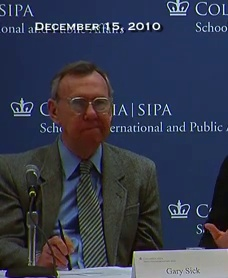

In [ ]:
# Controllo Ritaglio
speaker = 'lieberman' # bell   lieberman   long    sick   bollinger

track = txt_path.split('/')
track = track[-2]
track = track.split('_')
track = track[1]

print(f'SPEAKER: {speaker}\n')

test_SPEAK, test_NO_SPEAK = get_frames(video_path, df.iloc[[1800]], 80,130)
if len(test_SPEAK)>0:
  cv2.imwrite('test.jpg', test_SPEAK[0][0][0])
  display(ImageIPython('test.jpg'))
else:
  cv2.imwrite('test.jpg', test_NO_SPEAK[0][0][0])
  display(ImageIPython('test.jpg'))

In [ ]:
test_SPEAK[0][2]

64100

In [ ]:
caption_image(F_SPEAK[0][0][0], 'Is the person talking? Explain why in a few words')

In [ ]:
# Struttura: F_SPEAK[0] è il primo segmento di frames speak, F_SPEAK[0][0] è l'effettiva lista di frames, F_SPEAK[0][1] è il framenum iniziale
F_SPEAK, F_NO_SPEAK = get_frames(video_path, df, 80,130)
print(f'SPEAKER: {speaker}')

100%|██████████| 3897/3897 [00:09<00:00, 427.86it/s]



FRAME NEGATIVI 0
FRAME SPEAK 0
FRAME NO SPEAK 1
SPEAKER: lieberman


In [ ]:
#@title interpolation function
def interpolation(traj, start_frame_num, target_frame_num):
    new_traj = []
    original_frame_counts = []
    frame_nums = []
    for i in range(0, len(traj), target_frame_num):
        chunk = traj[i:i+target_frame_num]
        original_frame_count = len(chunk)
        while len(chunk) < target_frame_num:
            num_frames_to_add = min(target_frame_num - len(chunk), len(traj) - i)
            chunk = np.concatenate((chunk, traj[i:i+num_frames_to_add]))
        new_traj.append(np.array(chunk))
        original_frame_counts.append(original_frame_count)
        frame_nums.append((start_frame_num + i, start_frame_num + i + original_frame_count - 1))
    return new_traj, original_frame_counts, frame_nums

In [ ]:
# LOAD dict
prompt_dict = np.load("/content/drive/MyDrive/CLIP_embeddings/pretrained_text_embeddings.npy", allow_pickle=True).item()
len(prompt_dict)

10699

In [ ]:
#@title SAVE

correct_prompts = 0
tot_prompts = 0
count_before = len(prompt_dict)
weird_res = []
question = 'Is the person talking? Explain why in a few words'

if len(F_SPEAK)>0:
  for s in F_SPEAK: # s[0] list of frames, s[1] start framenum, s[2] end framenum
    interpolated_frames, original_frames, frame_nums = interpolation(s[0], s[1], 10)
    progress_bar = tqdm(total=len(interpolated_frames), position=0, leave=True)

    for ten_f, original_f, f_nums in zip(interpolated_frames,original_frames, frame_nums):

      prompt = caption_image(ten_f[4], question)

      if prompt.lower() == 'yes': correct_prompts += original_f #modifico
      elif prompt.lower() != 'no': weird_res.append(prompt)

      tot_prompts += original_f
      prompt_dict[f'{speaker}_{f_nums[0]}_{f_nums[1]}'] = (prompt)

      progress_bar.update(1)
    progress_bar.close()

if len(F_NO_SPEAK)>0:
  for s in F_NO_SPEAK: # s[0] list of frames, s[1] start framenum, s[2] end framenum
    interpolated_frames, original_frames, frame_nums = interpolation(s[0], s[1], 10)
    progress_bar = tqdm(total=len(interpolated_frames), position=0, leave=True)

    for ten_f, original_f, f_nums in zip(interpolated_frames,original_frames, frame_nums):

      prompt = caption_image(ten_f[4], question)

      if prompt.lower() == 'no': correct_prompts += original_f
      elif prompt.lower() != 'yes': weird_res.append(prompt)

      tot_prompts += original_f

      prompt_dict[f'{speaker}_{f_nums[0]}_{f_nums[1]}'] = (prompt)

      progress_bar.update(1)
    progress_bar.close()

count_after = len(prompt_dict)
print(f'\n\nTOT NEW ELEMENTS: {count_after-count_before} \nNEW DICT LENGTH: {count_after}')
print(f'tot count: {tot_prompts} \t correct count: {correct_prompts} \t weird_captions: {len(weird_res)} \nAccuracy: {round(correct_prompts/tot_prompts, 4)*100}%')

100%|██████████| 390/390 [10:55<00:00,  1.68s/it]



TOT NEW ELEMENTS: 390 
NEW DICT LENGTH: 13738
tot count: 3897 	 correct count: 3197 	 weird_captions: 0 
Accuracy: 82.04%


**Prompt Test**
*   59.90% = Is the person actively talking right now? Answer with Yes or No
*   59.90% = This person is participating in a conference, are they talking or listening right now? Answer with Talking or Listening
*   86.63% = Given the person’s gestures and facial cues in this image, are they actively engaged in a conversation? Answer with Yes or No
*   86.63% = Is the person in the image in the middle of a speech? Answer with Yes or No
*   88.61% = Given the person’s posture and facial cues in this image, are they actively talking right now? Answer with Yes or No



In [ ]:
# Get the first key
first_key = next(iter(prompt_dict))
print(f"First Key: {first_key} \t First caption: {prompt_dict[first_key]}")
last_key = next(reversed(prompt_dict))
print(f"Last Key: {last_key} \t Last caption: {prompt_dict[last_key]}")
print(f"Test: {prompt_dict['sick_142800_142809']}")

First Key: sick_25472_25481 	 First caption: No
Last Key: lieberman_155870_155879 	 Last caption: Yes
Test: Yes


In [ ]:
len(prompt_dict)

13738

In [ ]:
np.save("/content/drive/MyDrive/CLIP_embeddings/pretrained_text_embeddings.npy", prompt_dict)

**LLaVa Accuracy**


1.   sick=84%, bell=97%, bollinger=95.0%
2.   bollinger=88.0%, bell=87.92%
3.   bollinger=80.58%, bell=73.07%
4.   bell=94.28%, sick=71.07%, long=97.53%
5.   bell=89.44%, sick=81.67%, long=90.0%
6.   sick=81.61%, long=30.27%
7.   bollinger=95.16%, bell=100.0%
8.   lieberman=78.99%, lieberman=82.04%
9.   lieberman=74.72%
10.  bell=94.28%, sick=85.48%
11.  sick=71.13%
12.  long=11.97%
13.  long=99.51%, long=98.17%, long=100%, long=96.44%, lieberman=77.59%, long=100%
14.  lieberman=76.06%






**Frames per ogni track**

1 - 10000

2 - 2000

3 - 8540

4 - 11360

5 - 1801

6 - 11100

7 - 620

8 - 7600

9 - 2930

10 - 3200

11 - 1420

12 - 1420

13 - 4030

14 - 1880

In [ ]:
#@title Calcolo Accuratezza LLaVa per ogni speaker
# Initialize a dictionary to hold the total weighted accuracy and total frames for each person
totals = {"bell": [0, 0], "sick": [0, 0], "long": [0, 0], "lieberman": [0, 0], "bollinger": [0, 0]}

# List of accuracies for each dataset
accuracies = [
    {"sick": 84, "bell": 97, "bollinger": 95.0},
    {"bollinger": 88.0, "bell": 87.92},
    {"bollinger": 80.58, "bell": 73.07},
    {"bell": 94.28, "sick": 71.07, "long": 97.53},
    {"bell": 89.44, "sick": 81.67, "long": 90.0},
    {"sick": 81.61, "long": 30.27},
    {"bollinger": 95.16, "bell": 100.0},
    {"lieberman": 80.52},
    {"lieberman": 74.72},
    {"bell": 94.28, "sick": 85.48},
    {"sick": 71.13},
    {"long": 11.97},
    {"long": 98.52, "lieberman": 77.59},
    {"lieberman": 76.06}
]

# List of frames for each dataset
frames = [10000, 2000, 8540, 11360, 1801, 11100, 620, 7600, 2930, 3200, 1420, 1420, 4030, 1880]

# Calculate the total weighted accuracy and total frames for each person
for i in range(len(accuracies)):
    for person, accuracy in accuracies[i].items():
        totals[person][0] += accuracy * frames[i]
        totals[person][1] += frames[i]

# Calculate the overall accuracy for each person
overall_accuracies = {person: total[0] / total[1] for person, total in totals.items() if total[1] != 0}

print(overall_accuracies)


{'bell': 89.70059539990937, 'sick': 79.08372907075436, 'long': 67.99033354649792, 'lieberman': 78.25803527980536, 'bollinger': 88.52327032136105}


In [ ]:
vis_emb = np.load("/content/drive/MyDrive/CLIP_embeddings/pretrained_embeddings.npy", allow_pickle=True).item()

In [ ]:
# Convert the dictionary keys to sets
keys1 = set(vis_emb.keys())
keys2 = set(prompt_dict.keys())

# Find keys present in dict1 but not in dict2
missing_from_dict2 = keys1 - keys2
print("Keys present in dict1 but not in dict2:", missing_from_dict2)


Keys present in dict1 but not in dict2: set()


## Captions H5 Dataset

In [ ]:
!cp "/content/drive/MyDrive/Columbia Dataset/Speaker Frames/database.h5" "/content/data.h5"

In [ ]:
dataset_path = "/content/data.h5"

In [ ]:
text_captions = np.load("/content/drive/MyDrive/CLIP_embeddings/LLaVa_long_captions.npy", allow_pickle=True).item()
len(text_captions)

9874

In [ ]:
print(len(text_captions))
k = list(text_captions.keys())[0]
print(k)
print(text_captions[k])

3182
lieberman_0_9
('lieberman', 0, 'No, the person is not talking. He is sitting in front of a microphone, wearing a suit and tie, and looking at the camera.', 10)


In [ ]:
speaker = 'sick'
prompt = "Is the person talking or not? Explain why in a few words"

In [ ]:
#@title Get Captions from H5 Data
import h5py
start_len = len(text_captions)
with h5py.File(dataset_path, 'r') as f:
    person = f[speaker]
    frames = person['frames']
    labels = person['labels']
    frame_index = 0
    progress_bar = tqdm(total=len(labels), position=0, leave=True)
    while frame_index < len(frames):
        current_label = labels[frame_index]
        current_frames = []
        original_frames_count = 0
        while len(current_frames) < 10 and frame_index < len(frames):
            if labels[frame_index] == current_label:
                current_frames.append(frames[frame_index])
                original_frames_count += 1
                frame_index += 1
            else:
                break
        while len(current_frames) < 10:
            current_frames += current_frames[:10 - len(current_frames)]

        caption = caption_image(current_frames[4], prompt) # Ottengo la Caption sul frame centrale
        # if len(caption) > 250 or len(caption) < 20:
        #   print(f"attenzione lunghezza strana: {len(caption)}")
        key = f"{speaker}_{frame_index - len(current_frames)}_{frame_index - 1}"
        text_captions[key] = (speaker, current_label, caption, original_frames_count)
        progress_bar.update(10)
end_len = len(text_captions)

print(f"Nuovi aggiunti: {end_len-start_len} \t TOTALE: {end_len}")

38580it [3:19:08,  2.07it/s]

Nuovi aggiunti: 3858 	 TOTALE: 13732


In [ ]:
np.save("/content/drive/MyDrive/CLIP_embeddings/LLaVa_long_captions.npy", text_captions)

In [ ]:
count = 0
for k in list(text_captions.keys()):
  #if len(text_captions[k][2]) < 5: corte+=1 #print(text_captions[k][2])
  #print(len(tokenizer.tokenize(text_captions[k][2])))
  #print(text_captions[k][1], text_captions[k][2])
  if text_captions[k][2].lower().startswith("yes") or text_captions[k][2].lower().startswith("no"): count+=1
print(count)

13683


In [ ]:
max = 0
count = 0
for k in list(text_captions.keys()):
  #tok = clip.tokenize(text_captions[k][2])
  if len(text_captions[k][2])>max:
    count+=1
    max = len(text_captions[k][2])
print(count)
print(max)

9
239


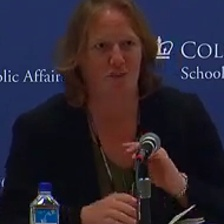

Yes, the person is talking. They are giving a speech or presentation at a podium, with a microphone to amplify their voice.


In [ ]:
import h5py
with h5py.File(dataset_path, 'r') as f:
  group = f['bell']
  frame = group['frames'][1000]
  cv2.imwrite('test.jpg', frame)
  display(ImageIPython('test.jpg'))
  caption = caption_image(frame, "Is the person talking or not? Explain why in a few words")
  if len(caption) > 250:
    print(f"attenzione lunghezza esagerata: {len(caption)}")
    caption = caption[:250]
  print(caption)

## CAPTIONS DA VIDEO VERSIONE AGGIORNATA

In [ ]:
# LOAD DICT
text_captions = np.load("/content/drive/MyDrive/CLIP_embeddings/LLaVa_long_captions_NEW.npy", allow_pickle=True).item()
len(text_captions)

10823

In [ ]:
#@title get_frames function
import cv2
from IPython.display import Image as ImageIPython, display

import warnings
warnings.filterwarnings('ignore')

def get_frames(path, df, add_width, add_height, move_right, move_lower):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, df.iloc[0]['framenum'])  # Set the starting frame
    progress_bar = tqdm(total=len(df), position=0, leave=True)
    frames = []
    labels= []
    frame_height = 360
    frame_width = 640
    try:
        for index, row in df.iterrows():
            ret, frame = cap.read()

            if row.TLx < 0 or row.TLy < 0:
                continue

            # Calculate the center of the box
            center_x = row.TLx + row.width // 2 + move_right
            center_y = row.TLy + row.width // 2 + move_lower

            # Calculate the new TLx and width
            half_width = max(0, (row.width + add_width) // 2)
            new_TLx = max(0, center_x - half_width)
            new_width = min(frame_width - new_TLx, row.width + add_width)

            # Calculate the new TLy and height
            half_height = max(0, (row.width + add_height) // 2)
            new_TLy = max(0, center_y - half_height)
            new_height = min(frame_height - new_TLy, row.width + add_height)

            # Crop the frame
            frame = frame[new_TLy : new_TLy + new_height, new_TLx : new_TLx + new_width]
            frame = frame[:, :, [2, 1, 0]]
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # lo fa già la riga sopra

            frames.append(frame)
            labels.append(row.speaking_status)

            progress_bar.update(1)

    finally:
        cap.release()
        cv2.destroyAllWindows()
        progress_bar.close()

    return frames, labels

In [ ]:
#@title Check Frame Crop
import matplotlib.pyplot as plt
def check_crop(path, df, add_width, add_height, move_right, move_lower):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, df.iloc[0]['framenum'])  # Set the starting frame
    frames = []
    labels = []
    for index, row in df.iterrows():
        ret, frame = cap.read()
        frame_height, frame_width = frame.shape[:2]

        if row.TLx < 0 or row.TLy < 0:
            continue

        # Calculate the center of the box
        center_x = row.TLx + row.width // 2 + move_right
        center_y = row.TLy + row.width // 2 + move_lower

        # Calculate the new TLx and width
        half_width = max(0, (row.width + add_width) // 2)
        new_TLx = max(0, center_x - half_width)
        new_width = min(frame_width - new_TLx, row.width + add_width)

        # Calculate the new TLy and height
        half_height = max(0, (row.width + add_height) // 2)
        new_TLy = max(0, center_y - half_height)
        new_height = min(frame_height - new_TLy, row.width + add_height)

        # Crop the frame
        frame = frame[new_TLy : new_TLy + new_height, new_TLx : new_TLx + new_width]
        frame = frame[:, :, [2, 1, 0]]
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # lo fa già la riga sopra

    cv2.imwrite('test.jpg', frame) # CROPPING ARBITRARIO
    img = cv2.imread('test.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
col_names = ['framenum', 'TLx', 'TLy', 'width', 'speaking_status']

video_path = "/content/drive/MyDrive/Columbia Dataset/Columbia 360.mp4"

txt_path = '/content/drive/MyDrive/Columbia Dataset/tracks_14_154000_155880/0.txt'

df = pd.read_csv(txt_path, sep='\t', header=None, names=col_names, index_col=False)
print(f'TOTAL FRAMES: {df.shape[0]}\nStart Frame: {df.iloc[0]["framenum"]}\nEnd Frame: {df.iloc[-1]["framenum"]}')

TOTAL FRAMES: 1880
Start Frame: 154000
End Frame: 155879


SPEAKER: lieberman


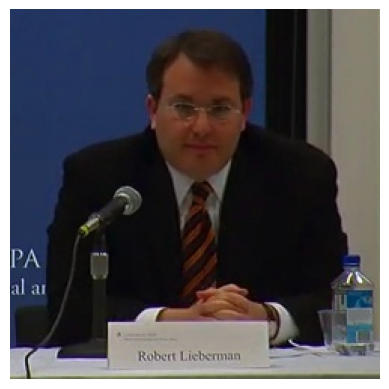

In [ ]:
speaker = 'lieberman' # bell   lieberman   long    sick   bollinger
print(f'SPEAKER: {speaker}')

crop = {
    'add_width': 80,
    'add_height': 80,
    'move_right': 0,
    'move_lower': 30
}

check_crop(video_path, df.iloc[[1500]], **crop)

In [ ]:
print(f'---- SPEAKER: {speaker.upper()} ----\n')
frames, labels = get_frames(video_path, df, **crop)

---- SPEAKER: LIEBERMAN ----



100%|██████████| 1880/1880 [00:03<00:00, 486.34it/s]


In [ ]:
#@title SAVE VERSIONE AGGIORNATA 2
prompt = "Is the person talking or not? explain why in a few words"

speaker_keys = [key for key in text_captions.keys() if key.startswith(speaker)]
if len(speaker_keys) == 0: start_index = 0
else:
  last_key = speaker_keys[-1]
  start_index = text_captions[last_key][3]
print(f"start frame index: {start_index}")

frame_index = start_index
last_index = 0
i = 0
progress_bar = tqdm(total=len(labels), position=0, leave=False)
start = len(text_captions)
while i < len(frames):
    current_label = labels[i]
    current_frames = []
    original_frames_count = 0
    while len(current_frames) < 10 and i < len(frames):
        if labels[i] == current_label:
            current_frames.append(frames[i])
            original_frames_count += 1
            frame_index += 1
            i+=1
        else:
            break
    # this While Loop deals with the Frame Interpolation
    while len(current_frames) < 10:
        current_frames += current_frames[:10 - len(current_frames)]

    caption = caption_image(current_frames[4], prompt)

    key = f"{speaker}_{frame_index - len(current_frames)}_{frame_index - 1}"

    text_captions[key] = (speaker, current_label, caption, frame_index)
    last_index = frame_index
    progress_bar.update(10)

end = len(text_captions)
print(f"\nNew Captions Added: {end-start}, dict size is: {end}")
print(f"{speaker} next start_index is: {last_index}")

start frame index: 14520


100%|██████████| 1880/1880 [10:58<00:00,  2.87it/s]


New Captions Added: 188, dict size is: 13737
lieberman next start_index is: 16400


In [ ]:
np.save("/content/drive/MyDrive/CLIP_embeddings/LLaVa_long_captions_NEW.npy", text_captions)
len(text_captions)

13737

In [ ]:
#@title compare keys
old_dict = np.load("/content/drive/MyDrive/CLIP_embeddings/LLaVa_long_captions.npy", allow_pickle=True).item()
old_keys = set(old_dict.keys())
new_keys = set(text_captions.keys())
print(new_keys <= old_keys) # if True then all new_keys are contained in the old keys

True


In [ ]:
chiavi = [k for k in text_captions.keys() if k.startswith('lieberman')]
len(chiavi)
# for c in chiavi:
#   print(text_captions[c])

1050

## RIPRENDO LE VECCHIE CHIAVI DEL DIZIONARIO

In [33]:
new_captions = np.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/LLaVa_long_captions_NEW.npy", allow_pickle=True).item()
old_captions = np.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/LLaVa_long_captions_smallcrop.npy", allow_pickle=True).item()
print(len(new_captions))
print(len(old_captions))

13737
13732


In [ ]:
#@title dividi le NUOVE Caption tra gli speaker (spero in ordine)

bell_files = []
bollinger_files = []
sick_files = []
long_files = []
lieberman_files = []

# Separate the embeddings based on the person's name
for key, (person, label, embedding, original_frames) in old_captions.items():
    if person == 'bell':
        bell_files.append((embedding.float(), label, original_frames))
    elif person == 'sick':
        sick_files.append((embedding.float(), label, original_frames))
    elif person == 'long':
        long_files.append((embedding.float(), label, original_frames))
    elif person == 'bollinger':
        bollinger_files.append((embedding.float(), label, original_frames))
    elif person == 'lieberman':
        lieberman_files.append((embedding.float(), label, original_frames))

print(f"Bell files: {len(bell_files)}")
print(f"Sick files: {len(sick_files)}")
print(f"Long files: {len(long_files)}")
print(f"Bollinger files: {len(bollinger_files)}")
print(f"Lieberman files: {len(lieberman_files)}")
print(f"TOT FILES: {len(bell_files)+len(sick_files)+len(long_files)+len(bollinger_files)+len(lieberman_files)}")

In [34]:
# ordino le chiavi di entrambi
keys_vis = sorted(list(old_captions.keys()))
keys_txt = sorted(list(new_captions.keys()))

In [32]:
FINAL_DICT = {} # conterrà le NUOVE caption con le chiavi giuste

In [ ]:
# Get the list of speakers
speakers = set(key.split('_')[0] for key in old_captions.keys())

for speaker in speakers:
    # Get the keys for this speaker in the old and new dictionaries
    old_keys = sorted([key for key in old_captions.keys() if key.split('_')[0] == speaker])
    new_keys = sorted([key for key in new_captions.keys() if key.split('_')[0] == speaker]) # <--- controllo le lunghezze

    print(f'{speaker} Old Keys: {len(old_keys)}')
    print(f'{speaker} New Keys: {len(new_keys)}')

    # For each old key
    for i, old_key in enumerate(old_keys): # tutte gli elementi oltre il numero di old_keys non verranno salvati
        new_key = new_keys[i]
        # Add the old key and new value to the final dictionary
        FINAL_DICT[old_key] = new_captions[new_key]
        if i<100: print(f'old key: {old_key}\tnew key: {new_key}')

In [16]:
np.save("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/LLaVa_long_captions_widecrops.npy", FINAL_DICT)

## LLaVA Accuracy using same Crop as CLIP (provo a misurare F1 score e altro)

In [ ]:
#Initialize previous prediction and correct predictions count
prev_caption = None
correct_predictions = {}
total_predictions = {}

# Iterate over the dictionary
#for key in list(text_captions.keys()):
for key in chiavi:
    speaker, label, caption, original_frames_count = text_captions[key]

    # Initialize speaker counts if not already done
    if speaker not in correct_predictions:
        correct_predictions[speaker] = 0
        total_predictions[speaker] = 0

    # If caption doesn't start with "yes" or "no", use the previous caption
    if not caption.lower().startswith(("yes", "no")) and prev_caption is not None:
        caption = prev_caption

    # Check if caption starts with "yes" and label is 1, or if caption is "no" and label is 0
    if (caption.lower().startswith("yes") and label == 1) or (caption.lower().startswith("no") and label == 0):
        correct_predictions[speaker] += original_frames_count

    # Update total predictions
    total_predictions[speaker] += original_frames_count

    # Update previous caption
    prev_caption = caption

# Calculate and print accuracy for each speaker
for speaker in correct_predictions:
    accuracy = (correct_predictions[speaker] / total_predictions[speaker]) * 100
    print(f"The accuracy for {speaker} is: {accuracy}%")

The accuracy for lieberman is: 99.05788503233731%


In [23]:
new_captions = np.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/LLaVa_long_captions_smallcrop.npy", allow_pickle=True).item()

In [31]:
from sklearn.metrics import accuracy_score, f1_score

prev_caption = None
y_true = []
y_pred = []

# Iterate over the dictionary
for key in [k for k in new_captions.keys() if k.startswith('lieberman')]:
    speaker, label, caption, original_frames_count = new_captions[key]

    # If caption doesn't start with "yes" or "no", use the previous caption
    if not caption.lower().startswith(("yes", "no")) and prev_caption is not None:
        caption = prev_caption

    # Check if caption starts with "yes" or "no"
    if caption.lower().startswith("yes"):
        y_pred.append(1)
    else:
        y_pred.append(0)

    y_true.append(label)

    # Update previous caption
    prev_caption = caption

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"The accuracy is: {accuracy}")

# Calculate and print macro F1 score
macro_f1_score = f1_score(y_true, y_pred, average='macro')
print(f"The macro F1 score is: {macro_f1_score}")

# Calculate and print weighted F1 score
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
print(f"The weighted F1 score is: {weighted_f1_score}")


The accuracy is: 0.8149726110772977
The macro F1 score is: 0.6378664315627067
The weighted F1 score is: 0.7696556251962795
